# Full processing for moraine dam displacement time series
Quinn Brencher 

In [1]:
# import packages
import os
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
from mintpy.utils import readfile, writefile, utils as ut, plot
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice
import gc
import pandas as pd
import seaborn as sns
from scipy.stats import linregress

In [2]:
# set up paths, directories, and variables for this specific dam
data_path = '/home/jovyan/repos/incubator_moraine_dam_analysis/data'
asc_burst = '012_023789_IW1'
des_burst = '121_258662_IW2'
asc_burst_path = f'{data_path}/data_igrams/{asc_burst}'
des_burst_path = f'{data_path}/data_igrams/{des_burst}'

dam_name = 'east_hongu_1'
proc_path = f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{dam_name}'

# define reference point, [y, x]
reference_point = [3073709.5, 495052.7]

# define crs 
crs = 32645

## Prepare input data

In [3]:
# read in dam polygon
dam_fn = f'../../mapping/polygons/{dam_name}_md.shp'
dam_gdf = gpd.read_file(dam_fn)

# # load in moving area polygon
# moving_fn = f'../../mapping/polygons/{dam_name}_bank_movement.shp'
# moving_gdf = gpd.read_file(moving_fn)

# pad dam bounds by 5 km 
padding = 5000
aoi_extent = [dam_gdf.bounds.minx.item()-padding,
               dam_gdf.bounds.maxy.item()+padding,
               dam_gdf.bounds.maxx.item()+padding,
               dam_gdf.bounds.miny.item()-padding]

In [4]:
def clip_hyp3_products_to_common_overlap(data_path: Union[str, Path], overlap: List[float]) -> None:    
    files_for_mintpy = ['_conncomp.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']
    for extension in files_for_mintpy:
        print(f'working on {extension}') 
        for file in data_path.rglob(f'*{extension}'):
            dst_file = file.parent / f'{file.stem}_{dam_name}{file.suffix}'
            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [ ]:
# clip igram products to dam aoi
clip_hyp3_products_to_common_overlap(Path(asc_burst_path), aoi_extent)
clip_hyp3_products_to_common_overlap(Path(des_burst_path), aoi_extent)

working on _conncomp.tif


/srv/conda/envs/mintpy/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


working on _corr.tif
working on _unw_phase.tif


## Examine coherence time series for dam

In [ ]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def hyp3_to_xarray(hyp3_dir, file_type='corr', epsg=32645, interpolate_na=False):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    
    for idir in dirs:
        tif_path = glob(f'{hyp3_dir}/{idir}/*/*{file_type}.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        dates = f'{tif_fn[14:22]}_{tif_fn[23:31]}' #parse filename for interferogram dates
        start_date = datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))
        
        src = src.rename({'band1':file_type})
        src = src.rio.write_crs(epsg)
        # in future, should get spatial baseline, flight dir, and orbit from metadata
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('dates')
    return ds 

In [ ]:
asc_corr_ds = hyp3_to_xarray(asc_burst_path, file_type=f'corr_{dam_name}')
des_corr_ds = hyp3_to_xarray(des_burst_path, file_type=f'corr_{dam_name}')

In [ ]:
# plot mean spatial coherence
f, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
asc_corr_ds[f'corr_{dam_name}'].mean(dim='dates').plot(ax=ax[0], vmin=0, vmax=1)
dam_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
ax[0].set_title('ascending mean coherence')
ax[0].scatter(reference_point[1], reference_point[0], c='k', s=5)
ax[0].set_aspect('equal')
des_corr_ds[f'corr_{dam_name}'].mean(dim='dates').plot(ax=ax[1], vmin=0, vmax=1)
dam_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
ax[1].scatter(reference_point[1], reference_point[0], c='k', s=5)
ax[1].set_title('descending mean coherence')
ax[1].set_aspect('equal')

In [ ]:
# clip datasets to dam polygon
asc_dam_corr_ds = asc_corr_ds.rio.clip(dam_gdf.geometry.values, crs=dam_gdf.crs, drop=True)
asc_dam_corr_ds = asc_dam_corr_ds.assign_coords(middle_date = ('dates', (asc_dam_corr_ds.t_baseline/2+asc_dam_corr_ds.start_date).data))

des_dam_corr_ds = des_corr_ds.rio.clip(dam_gdf.geometry.values, crs=dam_gdf.crs, drop=True)
des_dam_corr_ds = des_dam_corr_ds.assign_coords(middle_date = ('dates', (des_dam_corr_ds.t_baseline/2+des_dam_corr_ds.start_date).data))

# # clip datasets to moving polygon
# asc_dam_corr_ds = asc_corr_ds.rio.clip(moving_gdf.geometry.values, crs=moving_gdf.crs, drop=True)
# asc_dam_corr_ds = asc_dam_corr_ds.assign_coords(middle_date = ('dates', (asc_dam_corr_ds.t_baseline/2+asc_dam_corr_ds.start_date).data))

# des_dam_corr_ds = des_corr_ds.rio.clip(moving_gdf.geometry.values, crs=moving_gdf.crs, drop=True)
# des_dam_corr_ds = des_dam_corr_ds.assign_coords(middle_date = ('dates', (des_dam_corr_ds.t_baseline/2+des_dam_corr_ds.start_date).data))

In [ ]:
# plot seasonal changes in coherence 
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(asc_dam_corr_ds.middle_date.dt.dayofyear,
              asc_dam_corr_ds[f'corr_{dam_name}'].mean(dim=['x', 'y']),
              c=asc_dam_corr_ds.t_baseline.dt.days,
              label=asc_dam_corr_ds.t_baseline.dt.days)

ax[1].scatter(des_dam_corr_ds.middle_date.dt.dayofyear,
              des_dam_corr_ds[f'corr_{dam_name}'].mean(dim=['x', 'y']),
              c=des_dam_corr_ds.t_baseline.dt.days,
              label=des_dam_corr_ds.t_baseline.dt.days)
ax[0].set_xlabel('day of year of interferogram midpoint')
ax[0].set_ylabel('spatial mean coherence')
ax[0].set_title('ascending dam coherence')

ax[1].set_xlabel('day of year of interferogram midpoint')
ax[1].set_ylabel('spatial mean coherence')
ax[1].set_title('descending dam coherence')
f.tight_layout()

In [ ]:
# interpret plot
# if offsets will be needed to bridge summer gap, set use_offsets = True
use_offsets = False

In [ ]:
def get_summer_acquisitions(ds, min_doy=225, max_doy=275):
    ds_low = ds.where(ds.middle_date.dt.dayofyear > min_doy, drop=True)
    ds_low = ds_low.where(ds_low.middle_date.dt.dayofyear < max_doy, drop=True)
    date_string = ''
    for date in set(ds_low.start_date.dt.strftime('%Y%m%d').values):
        date_string += f'{date}, '
    return date_string

In [ ]:
# grab dates to remove if use_offsets is true
if use_offsets == True:
    asc_summer_acquisitions = get_summer_acquisitions(asc_dam_corr_ds)
    des_summer_acquisitions = get_summer_acquisitions(des_dam_corr_ds)
else:
    asc_summer_acquisitions = 'auto'
    des_summer_acquisitions = 'auto'

In [ ]:
# close datasets to free memory 
asc_corr_ds.close()
des_corr_ds.close()
asc_dam_corr_ds.close()
des_dam_corr_ds.close()

del asc_corr_ds
del des_corr_ds
del asc_dam_corr_ds
del des_dam_corr_ds
gc.collect()

## Calculate offset stacks to bridge gaps
only need this if there's a seasonal drop in coherence that can't be bridged with an interferogram

In [ ]:
def calculate_offset_stack(ds, dam_name, crs):
    # convert from pixels to phase
    ds['rng_off_radians'] = (ds[f'rng_off_{dam_name}']*2.3)*(12.5663706/0.05546576)
    da = xr.where(ds.rng_off_radians < -5000000, np.nan, ds.rng_off_radians)
    
    ones = xr.ones_like(offset_da)
    ones_masked = xr.where(offset_da.isnull(), 0, ones)
    t_baseline_broadcast = ones_masked*offset_da.t_baseline.dt.days
    
    mean_offset_per_day = offset_da.sum(dim='dates')/t_baseline_broadcast.sum(dim='dates')
    full_t_baseline = offset_da.end_date[-1] - offset_da.start_date[0]
    
    # scale to full temporal baseline
    full_displacement = mean_offset_per_day*full_t_baseline.dt.days
    
    # write crs, nodata, convert type
    full_displacement = full_displacement.astype(np.float32)
    full_displacement = full_displacement.rio.write_nodata(0, inplace=True)
    full_displacement = full_displacement.rio.write_crs(crs)
    
    return full_displacement

In [ ]:
# open offsets
asc_offset_ds = hyp3_to_xarray(f'{data_path}/data_offsets/{asc_burst}', file_type=f'rng_off_{dam_name}')
des_offset_ds = hyp3_to_xarray(f'{data_path}/data_offsets/{des_burst}', file_type=f'rng_off_{dam_name}')

In [ ]:
asc_stack = calculate_offset_stack(asc_offset_ds, dam_name, crs)
des_stack = calculate_offset_stack(des_offset_ds, dam_name, crs)

In [ ]:
# Function to write to text file
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

In [ ]:
# write out to rasters
os.makedirs(f'{data_path}/data_stacks/{asc_burst}', exist_ok=True)
date1 = asc_stack.start_date[0].dt.strftime('%Y%m%d').item()
date2 = asc_stack.end_date[-1].dt.strftime('%Y%m%d').item()
os.makedirs(f'{data_path}/data_stacks/{asc_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/', exist_ok=True)

asc_stack.rio.to_raster(f'{data_path}/data_stacks/{asc_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS_rng_off_unw_phase_{dam_name}.tif')

# create phony coherence and connected components
ones = xr.ones_like(asc_stack)
ones.rio.to_raster(f'{data_path}/data_stacks/{asc_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS_phonycorr_{dam_name}.tif')
ones.rio.to_raster(f'{data_path}/data_stacks/{asc_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS_phonyconncomp_{dam_name}.tif')

META_TXT = f'''Reference Granule: S1A_IW_SLC__1SSV_{date1}T121323_{date1}T121353_002884_00343C_D259
Secondary Granule: S1A_IW_SLC__1SSV_{date1}T121312_{date1}T121347_003059_0037F7_098A
Reference Pass Direction: ASCENDING
Reference Orbit Number: 2884
Secondary Pass Direction: ASCENDING
Secondary Orbit Number: 3059
Baseline: 0
UTC time: 1523.843923
Heading: -12.55120412179744
Spacecraft height: 693000.0
Earth radius at nadir: 6337286.638938101
Slant range near: 799643.0637567625
Slant range center: 824772.0502881967
Slant range far: 849901.0368196309
Range looks: 5
Azimuth looks: 1
INSAR phase filter: yes
Phase filter parameter: 0.5
Range bandpass filter: no
Azimuth bandpass filter: no
DEM source: GLO_30
DEM resolution (m): 30
Unwrapping type: snaphu_mcf
Speckle filter: yes
Water mask: False'''

write_config_file(f'{data_path}/data_stacks/{asc_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS.txt', META_TXT, mode='w')

In [ ]:
# write out to rasters
os.makedirs(f'{data_path}/data_stacks/{des_burst}', exist_ok=True)
date1 = des_stack.start_date[0].dt.strftime('%Y%m%d').item()
date2 = des_stack.end_date[-1].dt.strftime('%Y%m%d').item()
os.makedirs(f'{data_path}/data_stacks/{des_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/', exist_ok=True)

des_stack.rio.to_raster(f'{data_path}/data_stacks/{des_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS_rng_off_unw_phase_{dam_name}.tif')

# create phony coherence and connected components
ones = xr.ones_like(des_stack)
ones.rio.to_raster(f'{data_path}/data_stacks/{des_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS_phonycorr_{dam_name}.tif')
ones.rio.to_raster(f'{data_path}/data_stacks/{des_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS_phonyconncomp_{dam_name}.tif')

# fake metafile, none of this should actually matter
META_TXT = f'''Reference Granule: S1A_IW_SLC__1SSV_{date1}T121323_{date1}T121353_002884_00343C_D259
Secondary Granule: S1A_IW_SLC__1SSV_{date2}T121312_{date2}T121347_003059_0037F7_098A
Reference Pass Direction: DESCENDING
Reference Orbit Number: 2884
Secondary Pass Direction: DESCENDING
Secondary Orbit Number: 3059
Baseline: 0
UTC time: 1523.843923
Heading: -12.55120412179744
Spacecraft height: 693000.0
Earth radius at nadir: 6337286.638938101
Slant range near: 799643.0637567625
Slant range center: 824772.0502881967
Slant range far: 849901.0368196309
Range looks: 5
Azimuth looks: 1
INSAR phase filter: yes
Phase filter parameter: 0.5
Range bandpass filter: no
Azimuth bandpass filter: no
DEM source: GLO_30
DEM resolution (m): 30
Unwrapping type: snaphu_mcf
Speckle filter: yes
Water mask: False'''

write_config_file(f'{data_path}/data_stacks/{des_burst}/{date1}_{date2}/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS/S1_258661_IW2_{date1}_{date2}_VV_INT20_FFTS.txt', META_TXT, mode='w')

## run mintpy time series

In [ ]:
def run_mintpy(mintpy_path,
               data_dir,
               burst_name,
               dam_name,
               reference_point, 
               dam_gdf,
               use_offsets=False, 
               summer_acquisitions='auto'):
    
    if use_offsets == True:
        data_path = f'{data_dir}/data*/{burst_name}/*/*'
    else:
        data_path = f'{data_dir}/data_igrams/{burst_name}/*/*'      
    
    # write config text 
    CONFIG_TXT = f'''
    # vim: set filetype=cfg:
    ##------------------------ smallbaselineApp.cfg ------------------------##
    ########## computing resource configuration
    mintpy.compute.maxMemory = 30 #auto for 4, max memory to allocate in GB
    ## parallel processing with dask
    ## currently apply to steps: invert_network, correct_topography
    ## cluster   = none to turn off the parallel computing
    ## numWorker = all  to use all of locally available cores (for cluster = local only)
    ## numWorker = 80%  to use 80% of locally available cores (for cluster = local only)
    ## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
    mintpy.compute.cluster   = local #[local / slurm / pbs / lsf / none], auto for none, cluster type
    mintpy.compute.numWorker = 4 #[int > 1 / all / num%], auto for 4 (local) or 40 (slurm / pbs / lsf), num of workers
    mintpy.compute.config    = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name


    ########## 1. load_data
    ##---------add attributes manually
    ## MintPy requires attributes listed at: https://mintpy.readthedocs.io/en/latest/api/attributes/
    ## Missing attributes can be added below manually (uncomment #), e.g.
    # ORBIT_DIRECTION = ascending
    # PLATFORM = Sen
    # ...
    ## a. autoPath - automatic path pattern defined in mintpy.defaults.auto_path.AUTO_PATH_*
    ## b. load_data.py -H to check more details and example inputs.
    ## c. compression to save disk usage for ifgramStack.h5 file:
    ## no   - save   0% disk usage, fast [default]
    ## lzf  - save ~57% disk usage, relative slow
    ## gzip - save ~62% disk usage, very slow [not recommend]
    mintpy.load.processor       = hyp3 #[isce, aria, hyp3, gmtsar, snap, gamma, roipac, nisar], auto for isce
    mintpy.load.autoPath        = auto  #[yes / no], auto for no, use pre-defined auto path
    mintpy.load.updateMode      = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
    mintpy.load.compression     = auto  #[gzip / lzf / no], auto for no.
    ##---------interferogram stack:
    mintpy.load.unwFile         = {data_path}/S1*unw*{dam_name}.tif  #[path pattern of unwrapped interferogram files]
    mintpy.load.corFile         = {data_path}/S1*corr_{dam_name}.tif  #[path pattern of spatial coherence files]
    mintpy.load.connCompFile    = {data_path}/S1*conncomp_{dam_name}.tif  #[path pattern of connected components files], optional but recommended
    ##---------geometry:
    mintpy.load.demFile         = {data_path}/S1*dem_{dam_name}.tif   #[path of DEM file]
    mintpy.load.incAngleFile    = {data_path}/S1*lv_theta_{dam_name}.tif   #[path of incidence angle file], optional but recommended
    mintpy.load.azAngleFile     = {data_path}/S1*lv_phi_{dam_name}.tif   #[path of azimuth   angle file], optional
    ########## 2. modify_network
    ## 1) Network modification based on temporal/perpendicular baselines, date, num of connections etc.
    mintpy.network.tempBaseMax     = auto  #[1-inf, no], auto for no, max temporal baseline in days
    mintpy.network.perpBaseMax     = auto  #[1-inf, no], auto for no, max perpendicular spatial baseline in meter
    mintpy.network.connNumMax      = auto  #[1-inf, no], auto for no, max number of neighbors for each acquisition
    mintpy.network.startDate       = auto  #[20090101 / no], auto for no
    mintpy.network.endDate         = auto #20240124 #[20110101 / no], auto for no
    mintpy.network.excludeDate     = {summer_acquisitions}  #[20080520,20090817 / no], auto for no
    mintpy.network.excludeIfgIndex = auto  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
    mintpy.network.referenceFile   = auto  #[date12_list.txt / ifgramStack.h5 / no], auto for no

    ## 2) Data-driven network modification
    ## a - Coherence-based network modification = (threshold + MST) by default
    ## reference: Yunjun et al. (2019, section 4.2 and 5.3.1); Chaussard et al. (2015, GRL)
    ## It calculates a average coherence for each interferogram using spatial coherence based on input mask (with AOI)
    ## Then it finds a minimum spanning tree (MST) network with inverse of average coherence as weight (keepMinSpanTree)
    ## Next it excludes interferograms if a) the average coherence < minCoherence AND b) not in the MST network.
    mintpy.network.coherenceBased  = yes  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
    mintpy.network.minCoherence    = 0.55  #[0.0-1.0], auto for 0.7

    ## b - Effective Coherence Ratio network modification = (threshold + MST) by default
    ## reference: Kang et al. (2021, RSE)
    ## It calculates the area ratio of each interferogram that is above a spatial coherence threshold.
    ## This threshold is defined as the spatial coherence of the interferograms within the input mask.
    ## It then finds a minimum spanning tree (MST) network with inverse of the area ratio as weight (keepMinSpanTree)
    ## Next it excludes interferograms if a) the area ratio < minAreaRatio AND b) not in the MST network.
    mintpy.network.areaRatioBased  = auto  #[yes / no], auto for no, exclude interferograms with area ratio < minAreaRatio
    mintpy.network.minAreaRatio    = auto  #[0.0-1.0], auto for 0.75

    ## Additional common parameters for the 2) data-driven network modification
    mintpy.network.keepMinSpanTree = yes  #[yes / no], auto for yes, keep interferograms in Min Span Tree network
    mintpy.network.maskFile        = auto  #[file name, no], auto for waterMask.h5 or no [if no waterMask.h5 found]
    mintpy.network.aoiYX           = auto  #[y0:y1,x0:x1 / no], auto for no, area of interest for coherence calculation
    mintpy.network.aoiLALO         = {dam_gdf.bounds.miny.item()}:{dam_gdf.bounds.maxy.item()},{dam_gdf.bounds.minx.item()}:{dam_gdf.bounds.maxx.item()} #[S:N,W:E / no], auto for no - use the whole area

    ########## 3. reference_point
    ## Reference all interferograms to one common point in space
    ## auto - randomly select a pixel with coherence > minCoherence
    ## however, manually specify using prior knowledge of the study area is highly recommended
    ##   with the following guideline (section 4.3 in Yunjun et al., 2019):
    ## 1) located in a coherence area, to minimize the decorrelation effect.
    ## 2) not affected by strong atmospheric turbulence, i.e. ionospheric streaks
    ## 3) close to and with similar elevation as the AOI, to minimize the impact of spatially correlated atmospheric delay
    mintpy.reference.yx            = auto   #[257,151 / auto]
    mintpy.reference.lalo          = {reference_point[0]}, {reference_point[1]} # y, x, 28.003585, 88.480191  #[31.8,130.8 / auto]
    mintpy.reference.maskFile      = no   #[filename / no], auto for maskConnComp.h5
    mintpy.reference.coherenceFile = auto   #[filename], auto for avgSpatialCoh.h5
    mintpy.reference.minCoherence  = auto   #[0.0-1.0], auto for 0.85, minimum coherence for auto method


    ########## quick_overview
    ## A quick assessment of:
    ## 1) possible groud deformation
    ##    using the velocity from the traditional interferogram stacking
    ##    reference: Zebker et al. (1997, JGR)
    ## 2) distribution of phase unwrapping error
    ##    from the number of interferogram triplets with non-zero integer ambiguity of closue phase
    ##    reference: T_int in Yunjun et al. (2019, CAGEO). Related to section 3.2, equation (8-9) and Fig. 3d-e.


    ########## 4. correct_unwrap_error (optional)
    ## connected components (mintpy.load.connCompFile) are required for this step.
    ## SNAPHU (Chem & Zebker,2001) is currently the only unwrapper that provides connected components as far as we know.
    ## reference: Yunjun et al. (2019, section 3)
    ## supported methods:
    ## a. phase_closure          - suitable for highly redundant network
    ## b. bridging               - suitable for regions separated by narrow decorrelated features, e.g. rivers, narrow water bodies
    ## c. bridging+phase_closure - recommended when there is a small percentage of errors left after bridging
    mintpy.unwrapError.method          = no #bridging+phase_closure  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
    mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if not found]
    mintpy.unwrapError.connCompMinArea = 100  #[1-inf], auto for 2.5e3, discard regions smaller than the min size in pixels

    ## phase_closure options:
    ## numSample - a region-based strategy is implemented to speedup L1-norm regularized least squares inversion.
    ##     Instead of inverting every pixel for the integer ambiguity, a common connected component mask is generated,
    ##     for each common conn. comp., numSample pixels are radomly selected for inversion, and the median value of the results
    ##     are used for all pixels within this common conn. comp.
    mintpy.unwrapError.numSample       = auto  #[int>1], auto for 100, number of samples to invert for common conn. comp.

    ## bridging options:
    ## ramp - a phase ramp could be estimated based on the largest reliable region, removed from the entire interferogram
    ##     before estimating the phase difference between reliable regions and added back after the correction.
    ## bridgePtsRadius - half size of the window used to calculate the median value of phase difference
    mintpy.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
    mintpy.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 50, half size of the window around end points


    ########## 5. invert_network
    ## Invert network of interferograms into time-series using weighted least square (WLS) estimator.
    ## weighting options for least square inversion [fast option available but not best]:
    ## a. var - use inverse of covariance as weight (Tough et al., 1995; Guarnieri & Tebaldini, 2008) [recommended]
    ## b. fim - use Fisher Information Matrix as weight (Seymour & Cumming, 1994; Samiei-Esfahany et al., 2016).
    ## c. coh - use coherence as weight (Perissin & Wang, 2012)
    ## d. no  - uniform weight (Berardino et al., 2002) [fast]
    ## SBAS (Berardino et al., 2002) = minNormVelocity (yes) + weightFunc (no)
    mintpy.networkInversion.weightFunc      = var #[var / fim / coh / no], auto for var
    mintpy.networkInversion.waterMaskFile   = auto #[filename / no], auto for waterMask.h5 or no [if not found]
    mintpy.networkInversion.minNormVelocity = auto #[yes / no], auto for yes, min-norm deformation velocity / phase

    ## mask options for unwrapPhase of each interferogram before inversion (recommend if weightFunct=no):
    ## a. coherence              - mask out pixels with spatial coherence < maskThreshold
    ## b. connectComponent       - mask out pixels with False/0 value
    ## c. no                     - no masking [recommended].
    ## d. range/azimuthOffsetStd - mask out pixels with offset std. dev. > maskThreshold [for offset]
    mintpy.networkInversion.maskDataset   = auto #[coherence / connectComponent / rangeOffsetStd / azimuthOffsetStd / no], auto for no
    mintpy.networkInversion.maskThreshold = 0.6 #[0-inf], auto for 0.4
    mintpy.networkInversion.minRedundancy = auto #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition

    ## Temporal coherence is calculated and used to generate the mask as the reliability measure
    ## reference: Pepe & Lanari (2006, IEEE-TGRS)
    mintpy.networkInversion.minTempCoh  = 0.0 #[0.0-1.0], auto for 0.7, min temporal coherence for mask
    mintpy.networkInversion.minNumPixel = auto #[int > 1], auto for 100, min number of pixels in mask above
    mintpy.networkInversion.shadowMask  = auto #[yes / no], auto for yes [if shadowMask is in geometry file] or no.

    ########## 6. correct_troposphere (optional but recommended)
    ## correct tropospheric delay using the following methods:
    ## a. height_correlation - correct stratified tropospheric delay (Doin et al., 2009, J Applied Geop)
    ## b. pyaps - use Global Atmospheric Models (GAMs) data (Jolivet et al., 2011; 2014)
    ##      ERA5  - ERA5    from ECMWF [need to install PyAPS from GitHub; recommended and turn ON by default]
    ##      MERRA - MERRA-2 from NASA  [need to install PyAPS from Caltech/EarthDef]
    ##      NARR  - NARR    from NOAA  [need to install PyAPS from Caltech/EarthDef; recommended for N America]
    ## c. gacos - use GACOS with the iterative tropospheric decomposition model (Yu et al., 2018, JGR)
    ##      need to manually download GACOS products at http://www.gacos.net for all acquisitions before running this step
    mintpy.troposphericDelay.method = no  #[pyaps / height_correlation / gacos / no], auto for pyaps

    ## Notes for pyaps:
    ## a. GAM data latency: with the most recent SAR data, there will be GAM data missing, the correction
    ##    will be applied to dates with GAM data available and skipped for the others.
    ## b. WEATHER_DIR: if you define an environment variable named WEATHER_DIR to contain the path to a
    ##    directory, then MintPy applications will download the GAM files into the indicated directory.
    ##    MintPy application will look for the GAM files in the directory before downloading a new one to
    ##    prevent downloading multiple copies if you work with different dataset that cover the same date/time.
    mintpy.troposphericDelay.weatherModel = auto  #[ERA5 / MERRA / NARR], auto for ERA5
    mintpy.troposphericDelay.weatherDir   = auto  #[path2directory], auto for WEATHER_DIR or "./"

    ## Notes for height_correlation:
    ## Extra multilooking is applied to estimate the empirical phase/elevation ratio ONLY.
    ## For an dataset with 5 by 15 looks, looks=8 will generate phase with (5*8) by (15*8) looks
    ## to estimate the empirical parameter; then apply the correction to original phase (with 5 by 15 looks),
    ## if the phase/elevation correlation is larger than minCorrelation.
    mintpy.troposphericDelay.polyOrder      = auto  #[1 / 2 / 3], auto for 1
    mintpy.troposphericDelay.looks          = auto  #[1-inf], auto for 8, extra multilooking num
    mintpy.troposphericDelay.minCorrelation = auto  #[0.0-1.0], auto for 0

    ## Notes for gacos:
    ## Set the path below to directory that contains the downloaded *.ztd* files
    mintpy.troposphericDelay.gacosDir = auto # [path2directory], auto for "./GACOS"


    ########## 7. deramp (optional)
    ## Estimate and remove a phase ramp for each acquisition based on the reliable pixels.
    ## Recommended for localized deformation signals, i.e. volcanic deformation, landslide and land subsidence, etc.
    ## NOT recommended for long spatial wavelength deformation signals, i.e. co-, post- and inter-seimic deformation.
    mintpy.deramp          = no  #[no / linear / quadratic], auto for no - no ramp will be removed
    mintpy.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation


    ########## 8. correct_topography (optional but recommended)
    ## Topographic residual (DEM error) correction
    ## reference: Fattahi and Amelung (2013, IEEE-TGRS)
    ## stepFuncDate      - specify stepFuncDate option if you know there are sudden displacement jump in your area,
    ##                     e.g. volcanic eruption, or earthquake
    ## excludeDate       - dates excluded for the error estimation
    ## pixelwiseGeometry - use pixel-wise geometry (incidence angle & slant range distance)
    ##                     yes - use pixel-wise geometry if they are available [slow; used by default]
    ##                     no  - use the mean   geometry [fast]
    mintpy.topographicResidual                   = no  #[yes / no], auto for yes
    mintpy.topographicResidual.polyOrder         = auto  #[1-inf], auto for 2, poly order of temporal deformation model
    mintpy.topographicResidual.phaseVelocity     = auto  #[yes / no], auto for no - use phase velocity for minimization
    mintpy.topographicResidual.stepFuncDate      = auto  #[20080529,20190704T1733 / no], auto for no, date of step jump
    mintpy.topographicResidual.excludeDate       = auto  #[20070321 / txtFile / no], auto for exclude_date.txt
    mintpy.topographicResidual.pixelwiseGeometry = auto  #[yes / no], auto for yes, use pixel-wise geometry info


    ########## 9.1 residual_RMS (root mean squares for noise evaluation)
    ## Calculate the Root Mean Square (RMS) of residual phase time-series for each acquisition
    ## reference: Yunjun et al. (2019, section 4.9 and 5.4)
    ## To get rid of long spatial wavelength component, a ramp is removed for each acquisition
    ## Set optimal reference date to date with min RMS
    ## Set exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)
    mintpy.residualRMS.maskFile = linear  #[file name / no], auto for maskTempCoh.h5, mask for ramp estimation
    mintpy.residualRMS.deramp   = auto  #[quadratic / linear / no], auto for quadratic
    mintpy.residualRMS.cutoff   = auto  #[0.0-inf], auto for 3

    ########## 9.2 reference_date
    ## Reference all time-series to one date in time
    ## reference: Yunjun et al. (2019, section 4.9)
    ## no     - do not change the default reference date (1st date)
    mintpy.reference.date = no   #[reference_date.txt / 20090214 / no], auto for reference_date.txt


    ########## 10. velocity
    ## Estimate a suite of time functions [linear velocity by default]
    ## from final displacement file (and from tropospheric delay file if exists)
    mintpy.timeFunc.startDate   = auto   #[20070101 / no], auto for no
    mintpy.timeFunc.endDate     = auto   #[20101230 / no], auto for no
    mintpy.timeFunc.excludeDate = auto   #[exclude_date.txt / 20080520,20090817 / no], auto for exclude_date.txt

    ## Fit a suite of time functions
    ## reference: Hetland et al. (2012, JGR) equation (2-9)
    ## polynomial function    is  defined by its degree in integer. 1 for linear, 2 for quadratic, etc.
    ## periodic   function(s) are defined by a list of periods in decimal years. 1 for annual, 0.5 for semi-annual, etc.
    ## step       function(s) are defined by a list of onset times in str in YYYYMMDD(THHMM) format
    ## exp & log  function(s) are defined by an onset time followed by an charateristic time in integer days.
    ##   Multiple exp and log functions can be overlaied on top of each other, achieved via e.g.:
    ##   20110311,60,120          - two functions sharing the same onset time OR
    ##   20110311,60;20170908,120 - separated by ";"
    mintpy.timeFunc.polynomial = auto   #[int >= 0], auto for 1, degree of the polynomial function
    mintpy.timeFunc.periodic   = auto   #[1,0.5 / list_of_float / no], auto for no, periods in decimal years
    mintpy.timeFunc.stepDate   = auto   #[20110311,20170908 / 20120928T1733 / no], auto for no, step function(s)
    mintpy.timeFunc.exp        = auto   #[20110311,60 / 20110311,60,120 / 20110311,60;20170908,120 / no], auto for no
    mintpy.timeFunc.log        = auto   #[20110311,60 / 20110311,60,120 / 20110311,60;20170908,120 / no], auto for no

    ## Uncertainty quantification methods:
    ## a. residue    - propagate from fitting residue assuming normal dist. in time (Fattahi & Amelung, 2015, JGR)
    ## b. covariance - propagate from time series (co)variance matrix
    ## c. bootstrap  - bootstrapping (independently resampling with replacement; Efron & Tibshirani, 1986, Stat. Sci.)
    mintpy.timeFunc.uncertaintyQuantification = auto   #[residue, covariance, bootstrap], auto for residue
    mintpy.timeFunc.timeSeriesCovFile         = auto   #[filename / no], auto for no, time series covariance file
    mintpy.timeFunc.bootstrapCount            = auto   #[int>1], auto for 400, number of iterations for bootstrapping


    ########## 11.1 geocode (post-processing)
    # for input dataset in radar coordinates only
    # commonly used resolution in meters and in degrees (on equator)
    # 100,         90,          60,          50,          40,          30,          20,          10
    # 0.000925926, 0.000833334, 0.000555556, 0.000462963, 0.000370370, 0.000277778, 0.000185185, 0.000092593
    mintpy.geocode              = auto  #[yes / no], auto for yes
    mintpy.geocode.SNWE         = auto  #[-1.2,0.5,-92,-91 / none ], auto for none, output extent in degree
    mintpy.geocode.laloStep     = None  #[-0.000555556,0.000555556 / None], auto for None, output resolution in degree
    mintpy.geocode.interpMethod = auto  #[linear], auto for nearest, interpolation method
    mintpy.geocode.fillValue    = auto  #[np.nan, 0, ...], auto for np.nan, fill value for outliers.

    ########## 11.2 google_earth (post-processing)
    mintpy.save.kmz             = auto   #[yes / no], auto for yes, save geocoded velocity to Google Earth KMZ file

    ########## 11.3 hdfeos5 (post-processing)
    mintpy.save.hdfEos5         = auto   #[yes / no], auto for no, save time-series to HDF-EOS5 format
    mintpy.save.hdfEos5.update  = auto   #[yes / no], auto for no, put XXXXXXXX as endDate in output filename
    mintpy.save.hdfEos5.subset  = auto   #[yes / no], auto for no, put subset range info   in output filename

    ########## 11.4 plot
    # for high-resolution plotting, increase mintpy.plot.maxMemory
    # for fast plotting with more parallelization, decrease mintpy.plot.maxMemory
    mintpy.plot           = auto  #[yes / no], auto for yes, plot files generated by default processing to pic folder
    mintpy.plot.dpi       = auto  #[int], auto for 150, number of dots per inch (DPI)
    mintpy.plot.maxMemory = auto  #[float], auto for 4, max memory used by one call of view.py for plotting.
    '''
    
    os.chdir(mintpy_path)
    config_file = f'SenAT12.txt'
    write_config_file(config_file, CONFIG_TXT, mode='w')
    
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep load_data
    view.main('inputs/ifgramStack.h5 unwrapPhase-* -v -5 5 --zero-mask --noaxis --noverbose'.split())
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep modify_network
    plot_network.main('inputs/ifgramStack.h5 -t smallbaselineApp.cfg --figsize 12 4'.split())
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep reference_point
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep quick_overview
    plot.plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', disp_fig=True, fig_size=[14, 4])
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep correct_unwrap_error
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep invert_network
    view.main('avgSpatialCoh.h5 --noverbose'.split())
    view.main('temporalCoherence.h5 --noverbose'.split())
    view.main('timeseries.h5 -v -100 100 --noaxis'.split())
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep deramp
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep correct_topography
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep residual_RMS
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep reference_date
    !conda run -n mintpy smallbaselineApp.py SenAT12.txt --dostep velocity
    view.main('velocity.h5 --noverbose --vlim -0.5 0.5 -c RdBu'.split())

In [ ]:
asc_mintpy_path = 'asc_mintpy'

In [ ]:
# run ascending time series
# MAY WANT TO REPEAT WITH MOVING AREA POLYGON
os.chdir(proc_path)
os.makedirs(asc_mintpy_path, exist_ok=True)

run_mintpy(mintpy_path=asc_mintpy_path,
           data_dir=data_path,
           burst_name=asc_burst,
           dam_name=dam_name,
           reference_point=reference_point, 
           dam_gdf=dam_gdf,
           use_offsets=use_offsets, 
           summer_acquisitions=asc_summer_acquisitions)

In [ ]:
# write velocity to geotiff

# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, engine='h5netcdf', phony_dims='sort')
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                          'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

In [ ]:
os.chdir(proc_path)
asc_vel_ds = mintpy2d_to_xarray(f'{asc_mintpy_path}/velocity.h5', crs)
asc_vel_ds = asc_vel_ds.velocity.rio.write_nodata(0, inplace=True)
asc_vel_ds = asc_vel_ds * -1 # keep normal insar sign convention
asc_vel_ds.rio.to_raster(f'{asc_mintpy_path}/asc_mean_velocity_{dam_name}.tif')

In [ ]:
des_mintpy_path = 'des_mintpy'

In [ ]:
# run descending time series
os.chdir(proc_path)
os.makedirs(des_mintpy_path, exist_ok=True)

run_mintpy(mintpy_path=des_mintpy_path,
           data_dir=data_path,
           burst_name=des_burst,
           dam_name=dam_name,
           reference_point=reference_point, 
           dam_gdf=dam_gdf,
           use_offsets=use_offsets, 
           summer_acquisitions=des_summer_acquisitions)

In [28]:
os.chdir(proc_path)
des_vel_ds = mintpy2d_to_xarray(f'{des_mintpy_path}/velocity.h5', crs)
des_vel_ds = des_vel_ds.velocity.rio.write_nodata(0, inplace=True)
des_vel_ds = des_vel_ds * -1 # keep normal insar sign convention
des_vel_ds.rio.to_raster(f'{des_mintpy_path}/des_mean_velocity_{dam_name}.tif')

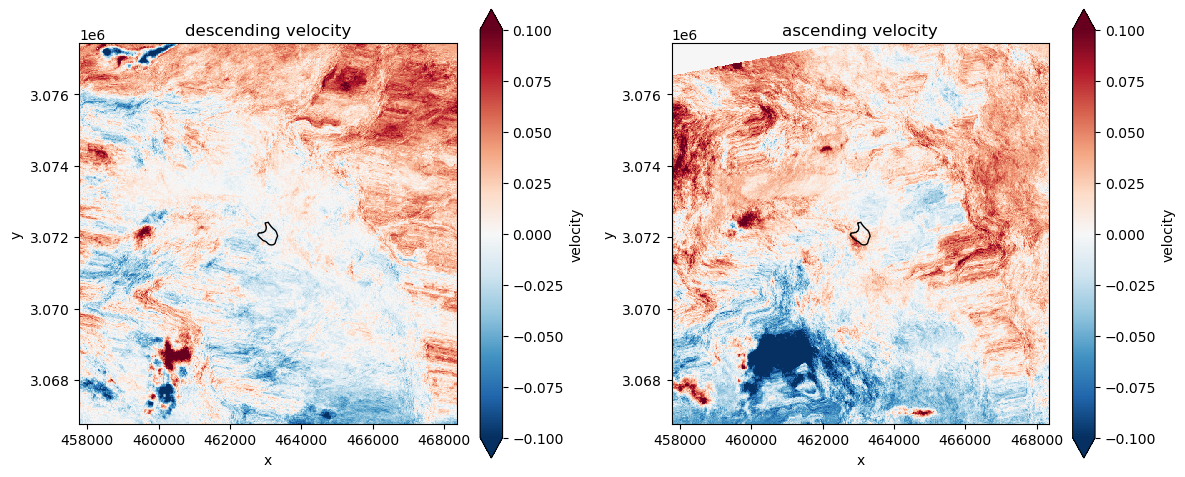

In [29]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
des_vel_ds.plot(ax=ax[0], vmin=-0.1, vmax=0.1, cmap='RdBu_r')
dam_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
ax[0].set_title('descending velocity')
asc_vel_ds.plot(ax=ax[1], vmin=-0.1, vmax=0.1, cmap='RdBu_r')
dam_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
ax[1].set_title('ascending velocity')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
f.tight_layout()

## decompose into EW and UD components

In [30]:
# function to read time series into xarray
def mintpyTS_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, cache=False)
    ds = ds.rename_dims({'phony_dim_1':'time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    ds = ds.rename({'timeseries': 'displacement'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'time': ('time', pd.to_datetime(ds.date)),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop(['bperp', 'date'])
    ds = ds.rio.write_crs(crs)
    
    return ds

In [31]:
os.chdir(proc_path)
# read ascending and descending time series into xarray ds
asc_ts_fn = f'{asc_mintpy_path}/timeseries.h5'
asc_ts_ds = mintpyTS_to_xarray(asc_ts_fn, crs)
asc_ts_ds = asc_ts_ds.rename({'displacement': 'asc_displacement'})

des_ts_fn = f'{des_mintpy_path}/timeseries.h5'
des_ts_ds = mintpyTS_to_xarray(des_ts_fn, crs)
des_ts_ds = des_ts_ds.rename({'displacement': 'des_displacement'})

# read geometry files into xarray ds
asc_geom_fn = f'{asc_mintpy_path}/inputs/geometryGeo.h5'
des_geom_fn = f'{des_mintpy_path}/inputs/geometryGeo.h5'
asc_geom_ds = mintpy2d_to_xarray(asc_geom_fn, crs)
des_geom_ds = mintpy2d_to_xarray(des_geom_fn, crs)

/tmp/ipykernel_3719/3877899153.py:12: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['bperp', 'date'])
/tmp/ipykernel_3719/3877899153.py:12: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['bperp', 'date'])


In [32]:
# find shorter time series and interpolate
asc_tspan = asc_ts_ds.time[-1] - asc_ts_ds.time[0]
des_tspan = des_ts_ds.time[-1] - des_ts_ds.time[0]

if des_tspan > asc_tspan:
    ts_ds = asc_ts_ds.assign(des_displacement=des_ts_ds.interp(time=asc_ts_ds.time).des_displacement)
    ts_ds['des_displacement'] = ts_ds['des_displacement'] - ts_ds['des_displacement'].isel(time=0)
elif asc_tspan > des_tspan:
    ts_ds = des_ts_ds.assign(asc_displacement=asc_ts_ds.interp(time=des_ts_ds.time).asc_displacement)
    ts_ds['asc_displacement'] = ts_ds['asc_displacement'] - ts_ds['asc_displacement'].isel(time=0)

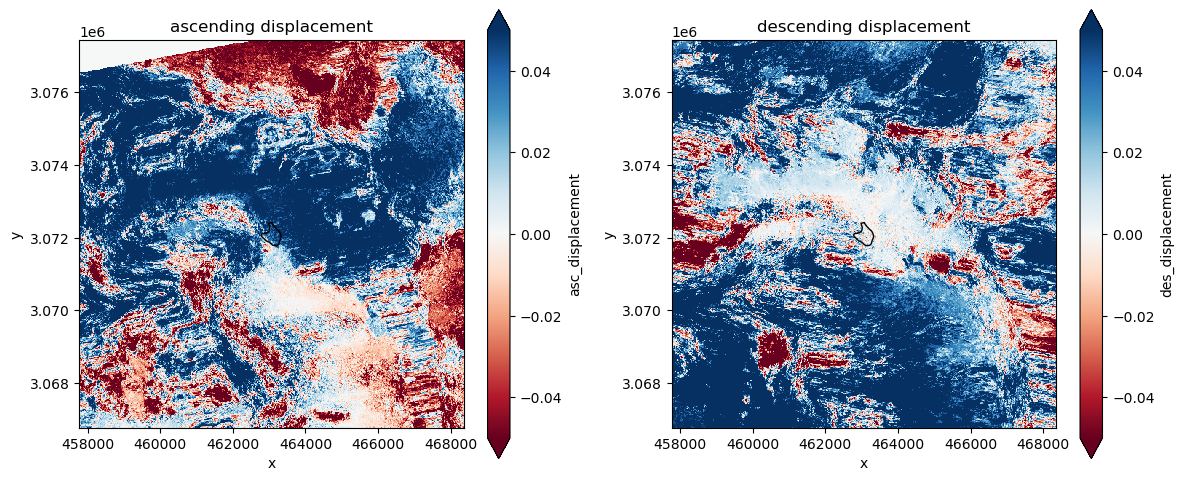

In [33]:
# plot time series for an arbitrary date
time_index = 20
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ts_ds.asc_displacement.isel(time=time_index).plot(ax=ax[0], cmap='RdBu', vmin=-0.05, vmax=0.05)
dam_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
ax[0].set_title('ascending displacement')
ts_ds.des_displacement.isel(time=time_index).plot(ax=ax[1], cmap='RdBu', vmin=-0.05, vmax=0.05)
dam_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
ax[1].set_title('descending displacement')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
plt.tight_layout()

In [34]:
# define azimuth angle from sensor to target relative to north
asc_geom_ds['azimuthAngle'] =  90 - (asc_geom_ds['azimuthAngle'] - 90)
des_geom_ds['azimuthAngle'] = np.abs(des_geom_ds['azimuthAngle'] + 90) + 270

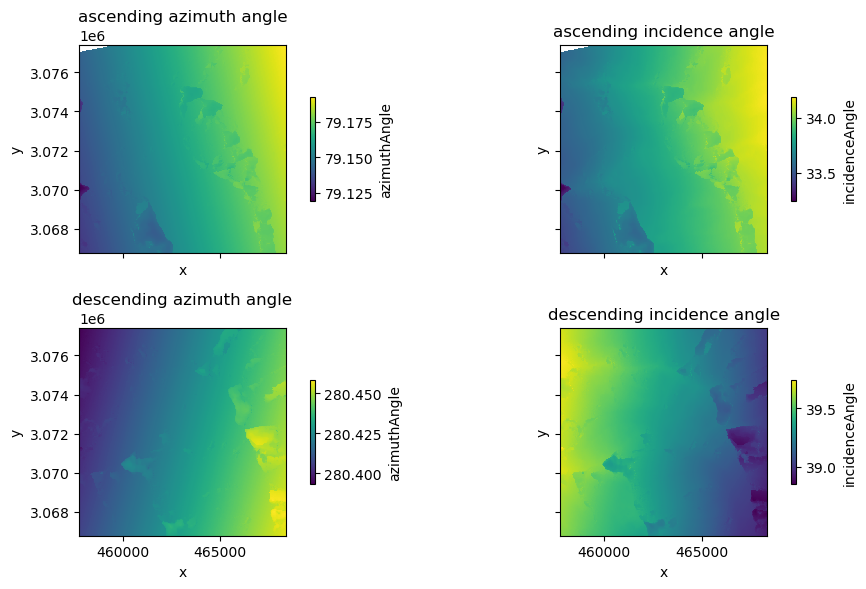

In [35]:
# plot ascending and descending azimuth and incidence angles
f, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
asc_geom_ds.azimuthAngle.plot(ax=ax[0,0], cbar_kwargs={'shrink': 0.5})
asc_geom_ds.incidenceAngle.plot(ax=ax[0,1], cbar_kwargs={'shrink': 0.5})
des_geom_ds.azimuthAngle.plot(ax=ax[1,0], cbar_kwargs={'shrink': 0.5})
des_geom_ds.incidenceAngle.plot(ax=ax[1,1], cbar_kwargs={'shrink': 0.5})
ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')
ax[1, 0].set_aspect('equal')
ax[1, 1].set_aspect('equal')
ax[0, 0].set_title('ascending azimuth angle')
ax[0, 1].set_title('ascending incidence angle')
ax[1, 0].set_title('descending azimuth angle')
ax[1, 1].set_title('descending incidence angle')
f.tight_layout()

In [36]:
# construct unit look vectors 
asc_geom_ds['n_hat'] = np.cos(np.radians(asc_geom_ds.azimuthAngle))*np.sin(np.radians(asc_geom_ds.incidenceAngle))
asc_geom_ds['e_hat'] = np.sin(np.radians(asc_geom_ds.azimuthAngle))*np.sin(np.radians(asc_geom_ds.incidenceAngle))
asc_geom_ds['z_hat'] = np.cos(np.radians(asc_geom_ds.incidenceAngle))

des_geom_ds['n_hat'] = np.cos(np.radians(des_geom_ds.azimuthAngle))*np.sin(np.radians(des_geom_ds.incidenceAngle))
des_geom_ds['e_hat'] = np.sin(np.radians(des_geom_ds.azimuthAngle))*np.sin(np.radians(des_geom_ds.incidenceAngle))
des_geom_ds['z_hat'] = np.cos(np.radians(des_geom_ds.incidenceAngle))

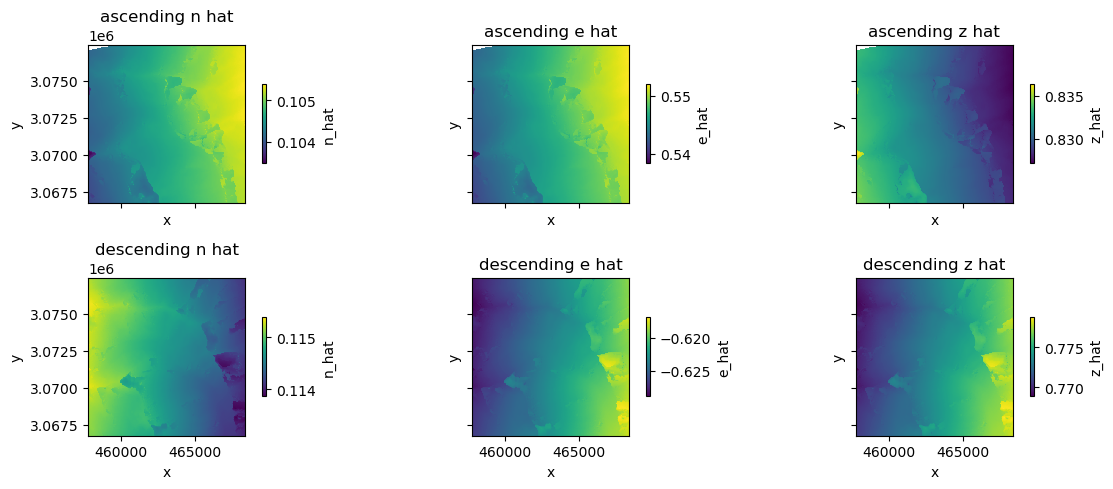

In [37]:
# plot unit look vectors 
f, ax = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
asc_geom_ds.n_hat.plot(ax=ax[0, 0], cbar_kwargs={'shrink': 0.5})
asc_geom_ds.e_hat.plot(ax=ax[0, 1], cbar_kwargs={'shrink': 0.5})
asc_geom_ds.z_hat.plot(ax=ax[0, 2], cbar_kwargs={'shrink': 0.5})

des_geom_ds.n_hat.plot(ax=ax[1, 0], cbar_kwargs={'shrink': 0.5})
des_geom_ds.e_hat.plot(ax=ax[1, 1], cbar_kwargs={'shrink': 0.5})
des_geom_ds.z_hat.plot(ax=ax[1, 2], cbar_kwargs={'shrink': 0.5})
ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')
ax[0, 2].set_aspect('equal')
ax[1, 0].set_aspect('equal')
ax[1, 1].set_aspect('equal')
ax[1, 2].set_aspect('equal')

ax[0, 0].set_title('ascending n hat')
ax[0, 1].set_title('ascending e hat')
ax[0, 2].set_title('ascending z hat')
ax[1, 0].set_title('descending n hat')
ax[1, 1].set_title('descending e hat')
ax[1, 2].set_title('descending z hat')
f.tight_layout()

In [39]:
# construct ud and ew unit vectors [n, e, d]
vertical_unit_vector = np.array([np.zeros_like(des_geom_ds['n_hat'].values), np.zeros_like(des_geom_ds['n_hat'].values), np.ones_like(des_geom_ds['n_hat'].values)])
horizontal_unit_vector = np.array([np.zeros_like(des_geom_ds['n_hat'].values), np.ones_like(des_geom_ds['n_hat'].values), np.zeros_like(des_geom_ds['n_hat'].values)])

In [40]:
# find dot products for LOS
asc_vertical = np.einsum('ijk,ijk->jk', np.array([asc_geom_ds['n_hat'].values, asc_geom_ds['e_hat'].values, asc_geom_ds['z_hat'].values]), vertical_unit_vector)
asc_horizontal = np.einsum('ijk,ijk->jk', np.array([asc_geom_ds['n_hat'].values, asc_geom_ds['e_hat'].values, asc_geom_ds['z_hat'].values]), horizontal_unit_vector)
des_vertical = np.einsum('ijk,ijk->jk', np.array([des_geom_ds['n_hat'].values, des_geom_ds['e_hat'].values, des_geom_ds['z_hat'].values]), vertical_unit_vector)
des_horizontal = np.einsum('ijk,ijk->jk', np.array([des_geom_ds['n_hat'].values, des_geom_ds['e_hat'].values, des_geom_ds['z_hat'].values]), horizontal_unit_vector)

In [41]:
# solve for horizontal and vertical displacement for all dates 
time_index = 20
ts_ds['vertical_displacement'] = (asc_horizontal*ts_ds.des_displacement - des_horizontal*ts_ds.asc_displacement)/(asc_horizontal*des_vertical - des_horizontal*asc_vertical)
ts_ds['horizontal_displacement'] = ((asc_vertical*ts_ds['vertical_displacement']) - ts_ds.asc_displacement)/-asc_horizontal

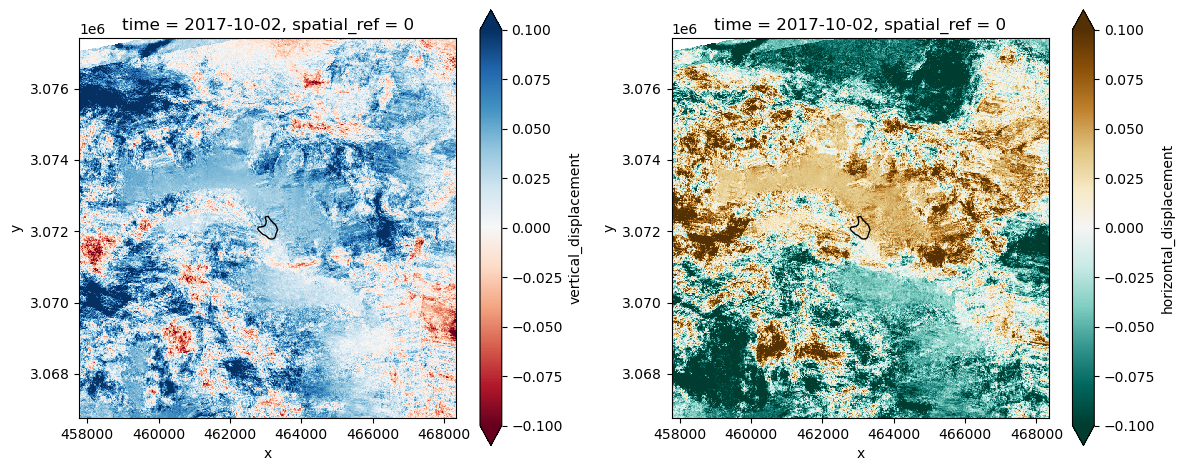

In [42]:
# plot cumulative ew and ud displacement for an arbitrary date
time_index = 20
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ts_ds.isel(time=time_index).vertical_displacement.plot(ax=ax[0], cmap='RdBu', vmin=-0.1, vmax=0.1)
dam_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
ts_ds.isel(time=time_index).horizontal_displacement.plot(ax=ax[1], cmap='BrBG_r', vmin=-0.1, vmax=0.1)
dam_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
f.tight_layout()

In [43]:
decimal_years = ((ts_ds['time'] - np.datetime64('1970-01-01T00:00:00'))/np.timedelta64(1, 'ns')/1e9/3600/24/365.25)+1970
ts_ds = ts_ds.assign_coords(decimal_year = ('time', decimal_years.data))

In [44]:
# Function to fit a line to a 1D array and return the slope
def fit_line(x, y):
    valid_indices = ~np.isnan(y)
    try: 
        slope, _, _, _, _ = linregress(x[valid_indices], y[valid_indices])
    except: 
        return np.nan
    else:
        return slope

In [45]:
vertical_veloc = xr.apply_ufunc(fit_line, ts_ds.decimal_year, ts_ds.vertical_displacement, input_core_dims=[['time'], ['time']], vectorize=True)
horizontal_veloc = xr.apply_ufunc(fit_line, ts_ds.decimal_year, ts_ds.horizontal_displacement, input_core_dims=[['time'], ['time']], vectorize=True)

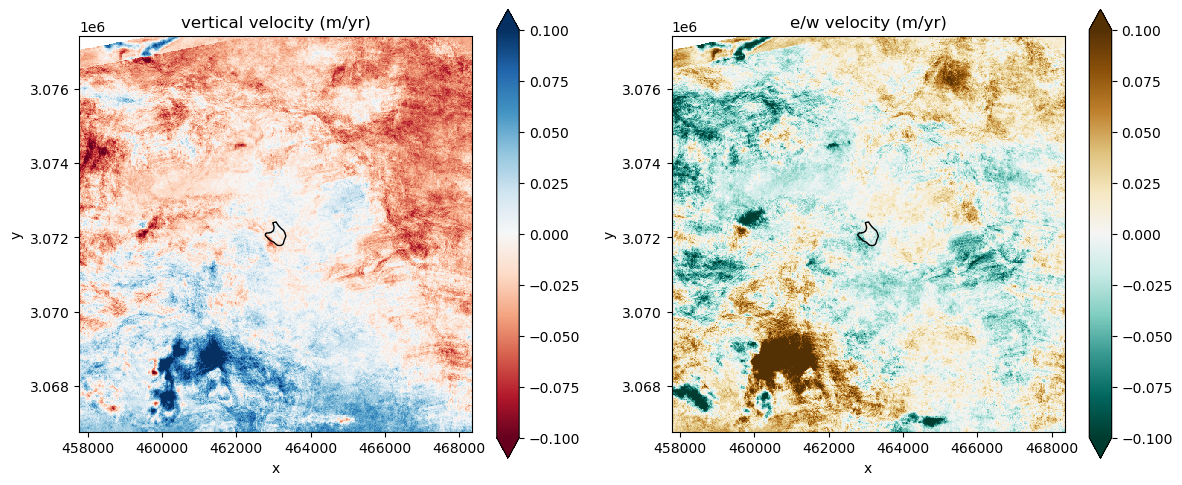

In [46]:
# plot cumulative ew and ud displacement for an arbitrary date
time_index = 20
f, ax = plt.subplots(1, 2, figsize=(12, 5))
vertical_veloc.plot(ax=ax[0], cmap='RdBu', vmin=-0.1, vmax=0.1)
dam_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
horizontal_veloc.plot(ax=ax[1], cmap='BrBG_r', vmin=-0.1, vmax=0.1)
dam_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
ax[0].set_title('vertical velocity (m/yr)')
ax[1].set_title('e/w velocity (m/yr)')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
f.tight_layout()

In [47]:
# write to rasters
vertical_veloc = vertical_veloc.rio.write_crs(crs)
vertical_veloc.rio.to_raster(f'vertical_velocity_{dam_name}.tif')
horizontal_veloc = horizontal_veloc.rio.write_crs(crs)
horizontal_veloc.rio.to_raster(f'ew_velocity_{dam_name}.tif')

## spatial analyis

In [ ]:
# # load in moving area polygon
# moving_fn = f'../../mapping/polygons/{dam_name}_bank_movement.shp'
# moving_gdf = gpd.read_file(moving_fn)

In [48]:
moving_ts = ts_ds.rio.clip(dam_gdf.geometry, crs=dam_gdf.crs, drop=True)

In [49]:
os.makedirs('figs', exist_ok=True)

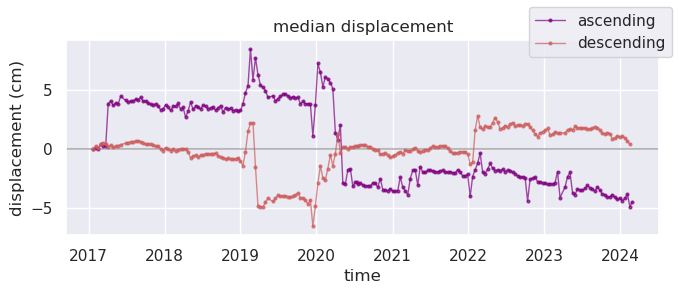

In [55]:
# ascending and descending only
sns.set_theme()
f, ax = plt.subplots(figsize=(7,3))
ax.axhline(y=0, c='gray', alpha=0.5)
(moving_ts.asc_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax, c='purple', marker='o', markersize=2, linewidth=1, alpha=0.7, label='ascending')
(moving_ts.des_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax, c='indianred', marker='o', markersize=2, linewidth=1, alpha=0.7, label='descending')
ax.set_ylabel('displacement (cm)')
ax.set_title('median displacement')
f.tight_layout()
f.legend()
plt.savefig(f'./figs/{dam_name}_los_ts.png', dpi=300)

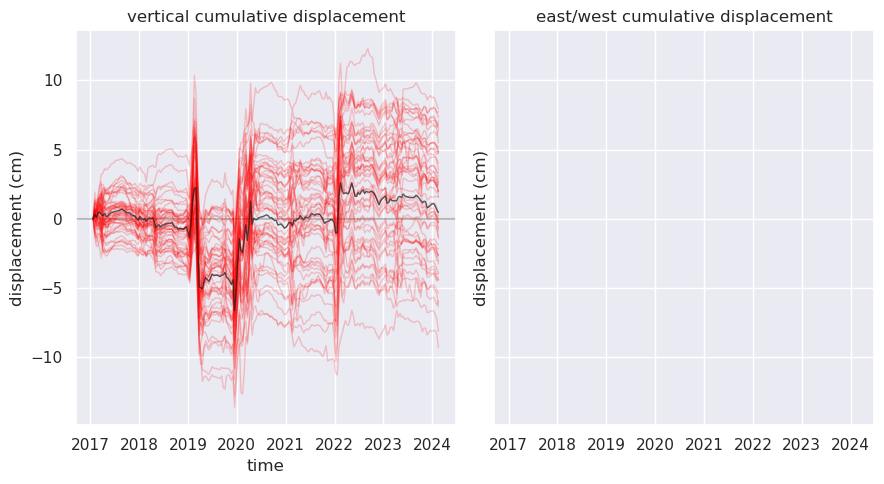

In [51]:
f, ax = plt.subplots(1, 2, figsize=(9,5), sharex=True, sharey=True)
ax[0].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts.x)):
    for y in range(len(moving_ts.y)):
        if (x+1) % 3 + (y+1) % 3 == 0:
            (moving_ts.des_displacement.isel(x=x, y=y)*100).plot(ax=ax[0], c='red', linewidth=1, alpha=0.2)
(moving_ts.des_displacement.median(dim=('x', 'y'))*100).plot(ax=ax[0], c='k', linewidth=1, alpha=0.7)

# ax[1].axhline(y=0, c='gray', alpha=0.5)
# for x in range(len(moving_ts.x)):
#     for y in range(len(moving_ts.y)):
#         if (x+1) % 3 + (y+1) % 3 == 0:
#             (moving_ts.asc_displacement.isel(x=x, y=y)*100).plot(ax=ax[1], c='orchid', linewidth=1, alpha=0.2)
# (moving_ts.asc_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax[1], c='k', linewidth=1, alpha=0.7)

ax[0].set_title('vertical cumulative displacement')
ax[0].set_ylabel('displacement (cm)')
ax[1].set_title('east/west cumulative displacement')
ax[1].set_ylabel('displacement (cm)')
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_los_pixels_ts.png', dpi=300)

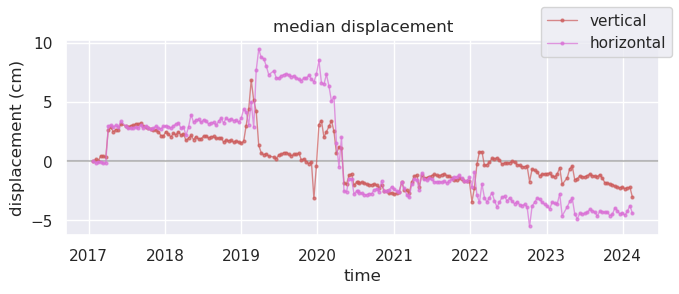

In [52]:
# ew and up/down only
sns.set_theme()
f, ax = plt.subplots(figsize=(7,3))
ax.axhline(y=0, c='gray', alpha=0.5)
(moving_ts.vertical_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax, c='indianred', marker='o', markersize=2, linewidth=1, alpha=0.7, label='vertical')
(moving_ts.horizontal_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax, c='orchid', marker='o', markersize=2, linewidth=1, alpha=0.7, label='horizontal')
ax.set_ylabel('displacement (cm)')
ax.set_title('median displacement')
f.tight_layout()
f.legend()
plt.savefig(f'./figs/{dam_name}_ts.png', dpi=300)

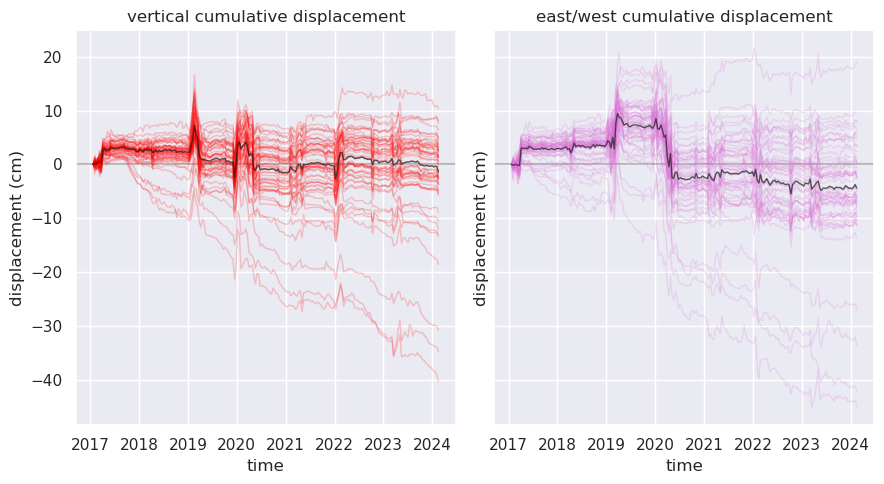

In [53]:
f, ax = plt.subplots(1, 2, figsize=(9,5), sharex=True, sharey=True)
ax[0].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts.x)):
    for y in range(len(moving_ts.y)):
        if (x+1) % 3 + (y+1) % 3 == 0:
            (moving_ts.vertical_displacement.isel(x=x, y=y)*100).plot(ax=ax[0], c='red', linewidth=1, alpha=0.2)
(moving_ts.vertical_displacement.median(dim=('x', 'y'))*100).plot(ax=ax[0], c='k', linewidth=1, alpha=0.7)

ax[1].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts.x)):
    for y in range(len(moving_ts.y)):
        if (x+1) % 3 + (y+1) % 3 == 0:
            (moving_ts.horizontal_displacement.isel(x=x, y=y)*100).plot(ax=ax[1], c='orchid', linewidth=1, alpha=0.2)
(moving_ts.horizontal_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax[1], c='k', linewidth=1, alpha=0.7)

ax[0].set_title('vertical cumulative displacement')
ax[0].set_ylabel('displacement (cm)')
ax[1].set_title('east/west cumulative displacement')
ax[1].set_ylabel('displacement (cm)')
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_decomp_pixels_ts.png', dpi=300)

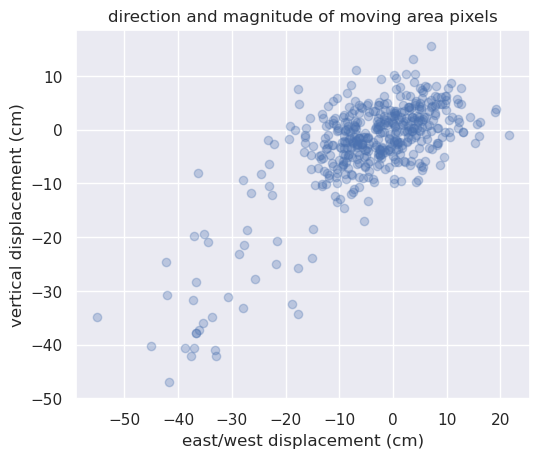

In [54]:
# vertical and ew displacement for an arbitrary time step
time_index = -2
f, ax = plt.subplots()
ax.scatter((moving_ts.horizontal_displacement.isel(time=time_index).values.ravel()*100),
           (moving_ts.vertical_displacement.isel(time=time_index).values.ravel()*100),
           alpha=0.3)
ax.set_xlabel('east/west displacement (cm)')
ax.set_ylabel('vertical displacement (cm)')
ax.set_aspect('equal')
ax.set_title('direction and magnitude of moving area pixels')
plt.savefig(f'./figs/{dam_name}_scatter_ts.png', dpi=300)